In [562]:
# initialize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arabic_reshaper import reshape
from bidi.algorithm import get_display
import jdatetime
import re
import json
from collections import defaultdict, Counter

# function to add Jalali date column
def add_jalali_column(df, year_col, month_col, day_col, new_col_name='j_date'):
    def _convert(row):
        # Return None if year is missing
        if pd.isna(row[year_col]): return None

        month_list = ['فروردین','اردیبهشت', 'خرداد', 'تیر', 'مرداد', 'شهریور', 'مهر', 'آبان', 'آذر', 'دی', 'بهمن',  'اسفند']
        month_dict = {month: i+1 for i, month in enumerate(month_list)}
        # Default month/day to 1 if NaN
        y = int(row[year_col])
        m = month_dict.get(row[month_col], 1) if pd.notna(row[month_col]) else 1
        d = int(row[day_col]) if pd.notna(row[day_col]) else 1
        
        try:
            return jdatetime.date(y, m, d)
        except ValueError:
            # Fix cases where d=31 but month only has 30 days
            if d == 31:
                try: return jdatetime.date(y, m, 30)
                except ValueError: return None
            return None

    df[new_col_name] = df.apply(_convert, axis=1)
    return df

# function to fix persian text display issues
def fix_persian_text(text):
    if not isinstance(text, str) or pd.isna(text):
        return text
    # 1. Reshape: Connects the letters (e.g., ت + ه + ر + ا + ن -> تهران)
    reshaped_text = reshape(text)
    # 2. Bidi: Reverses the string for correct RTL display
    return get_display(reshaped_text)

# function to clean persian text of special characters
def clean_persian_text(text):
    # 1. Replace newlines and tabs with a space
    text = text.replace('\n', ' ').replace('\t', ' ')
    
    # 2. Remove ZWNJ (Optional: keep it if you want correct grammar)
    text = text.replace('\u200c', '')
    
    # 3. Regex to keep only:
    # \u0600-\u06FF: Standard Persian/Arabic characters
    # \uFB50-\uFDFF and \uFE70-\uFEFF: Persian presentation forms (extended letters)
    # 0-9: Numbers
    # \s: Whitespace
    pattern = r'[^\u0600-\u06FF\uFB50-\uFDFF\uFE70-\uFEFF0-9\s]'
    
    # Apply the pattern (replaces special symbols/punctuation with nothing)
    cleaned = re.sub(pattern, '', text)
    
    # 4. Remove extra spaces caused by the replacements
    cleaned = " ".join(cleaned.split())
    
    return cleaned

# function to read data from jsonl file and store it as flattened dataframes
def read_data_from_jsonl(file_path):
    full_df = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            full_df.append(json.loads(line))
    # flatten list variables 
    full_df = pd.json_normalize(full_df)

    vars_to_explode = ['topics','targets','persons']
    exploded_df_list = []
    for var in vars_to_explode:
        df = full_df.drop(columns=list(set(vars_to_explode)-{var})).explode(var).reset_index()
        df = pd.concat([df.drop(var, axis=1), df[var].apply(pd.Series).add_prefix(var[:-1]+"_")], axis=1)
        exploded_df_list.append(df)

    return exploded_df_list # list of: [df_topics, df_targets, df_persons]



In [ ]:
# setup for AI prompt calls
import os
import json
import time
from google import genai
from dotenv import load_dotenv
from google.api_core import exceptions

load_dotenv()
api_key = os.getenv("GEMINI_API_KEY")
client = genai.Client(api_key=api_key)

def get_prompt_response(prompt_text, model="gemini-2.5-flash-lite"):
    for wait_time in [2, 4, 8, 16, 32]:
        try:
            response = client.models.generate_content(
                model=model, 
                contents=prompt_text,
                config={ 'response_mime_type': 'application/json' }
            )
            return json.loads(response.text)
        
        except exceptions.ServiceUnavailable: # This is the "overloaded" error
            print(f"Server busy. Retrying in {wait_time}s...")
            time.sleep(wait_time)

        except Exception as e:
            print(f"Connection or Parsing Error: {e}")
            return None

In [373]:
# read Khomeini excel data with persian text

Sahifeh_df = pd.read_excel('data/sahifeh.xlsx', sheet_name='Sheet1')
Sahifeh_df.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)
Sahifeh_df = add_jalali_column(Sahifeh_df, 'year', 'month', 'day', new_col_name='j_date')
Sahifeh_df.info()
#clean all text colums
for col in ['subject', 'type', 'body', 'addressed_to']:
    # Sahifeh_df[col] = Sahifeh_df[col].apply(lambda x: clean_persian_text(x) if isinstance(x, str) else x)
    Sahifeh_df[col] = Sahifeh_df[col].fillna('').astype(str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4333 entries, 0 to 4332
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subject       4274 non-null   object 
 1   type          4333 non-null   object 
 2   year          4271 non-null   float64
 3   month         4161 non-null   object 
 4   day           4016 non-null   float64
 5   place         4315 non-null   object 
 6   addressed_to  2956 non-null   object 
 7   body          4331 non-null   object 
 8   full_date     4329 non-null   object 
 9   j_date        4271 non-null   object 
dtypes: float64(2), object(8)
memory usage: 338.6+ KB


In [374]:
# cleaning and filtering
# prior to 22 بهمن 1357
Sahifeh_df = Sahifeh_df[Sahifeh_df['j_date'] <= jdatetime.date(1357, 11, 22)]
Sahifeh_df['date'] = Sahifeh_df['j_date'].apply(lambda x: x.togregorian() if x is not None else None)
Sahifeh_df['date'] = pd.to_datetime(Sahifeh_df['date'])
# keep only specific types  
types_to_keep = ['سخنرانی', 'نامه', 'پیام', 'بیانات', 'گفتگو', 'فرمان']
Sahifeh_df = Sahifeh_df[Sahifeh_df['type'].apply(lambda x: any(word in x for word in types_to_keep))]

# drop personal or irrelevant subjects
subjects_to_drop = ['خانوادگی','وجوه شرعی','احوالپرسی','اعلام وصول نامه',
                       'اعلام وصول نامه ارسالی','شهریه طلاب', 'تشکر']
Sahifeh_df = Sahifeh_df[~Sahifeh_df['subject'].apply(lambda x: any(word in x for word in subjects_to_drop))]
# print(Sahifeh_df['subject'].value_counts())

### Extracting topics and sentiments from each entry individually

In [375]:

def analyze_transcript_with_AI(transcript):
    # read prompt text from file
    with open("lvl1_prompt_single_article.txt", "r", encoding="utf-8") as f:
        prompt_instructions = f.read()
    # Combine instructions with the transcript
    prompt = f"{prompt_instructions}\n\nمتن:\n{transcript}"
    return get_prompt_response(prompt)

# get results for a subsample
os.path.exists("lvl1_failed_index.log") and os.remove("lvl1_failed_index.log")
os.path.exists("lvl1_results.jsonl") and os.remove("lvl1_results.jsonl")

for index, row in Sahifeh_df.iterrows():
    result = analyze_transcript_with_AI(row['body'])
    
    # time.sleep(4)  # to avoid rate limiting, unnecessary if using paid tier API
    if result is None:
        with open("lvl1_failed_index.log","a") as f:
            f.write(str(index) + "\n")
    else:
        with open("lvl1_results.jsonl", "a", encoding="utf-8") as f:
            json_record = json.dumps(result | row.to_dict(), ensure_ascii=False, default=str)
            f.write(json_record + "\n")



Connection or Parsing Error: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
Connection or Parsing Error: Extra data: line 68 column 1 (char 1174)
Connection or Parsing Error: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
Connection or Parsing Error: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
Connection or Parsing Error: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
Connection or Parsing Error: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
Connection or Parsing Error: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 's

### Linguistic Synchronization

Using the topics and conceptual targets created using based on the individual transcript prompts, Synchronise them throughout the entire dataset, such that the same concept is associated with only a single phrasing, so we can follow the sentiments for a certain concept or topic across time and across speeches, messages, etc. 

In [ ]:
# Synchronnization prompt call
def Synchronnize_phrases_with_AI(input_set_of_strings):
    # read prompt text from file
    with open("lvl2_prompt_Linguistic_Synchronization.txt", "r", encoding="utf-8") as f:
        prompt_instructions = f.read()
    
    prompt = f"{prompt_instructions}\n\nمتن:\n{input_set_of_strings}"
    return get_prompt_response(prompt)

# read all targets 
all_targets = set()
with open('lvl1_results.jsonl', 'r+', encoding='utf-8') as f:
    for line in f:
        entry = json.loads(line)
        for t, target in enumerate(entry['targets']):
            all_targets.add(target['text'])

print("total characters:",sum(len(s) for s in all_targets))

all_targets_Synchronnized = Synchronnize_phrases_with_AI(all_targets)

# merge into results
os.path.exists("lvl2_results.jsonl") and os.remove("lvl2_results.jsonl")

df_topics, df_targets, df_persons = read_data_from_jsonl('lvl1_results.jsonl')
df_targets['target_text_sync']  = df_targets['target_text'].apply(lambda x: all_targets_Synchronnized[x] if x in all_targets_Synchronnized.keys() else x)

df_targets.to_csv('lvl2_results_df_targets.csv', index=False, encoding='utf-8-sig')
df_topics.to_csv('lvl2_results_df_topics.csv', index=False, encoding='utf-8-sig')
df_persons.to_csv('lvl2_results_df_persons.csv', index=False, encoding='utf-8-sig')

total characters: 27290


### Conceptual Clustering

Now using the list of Synchronnized concepts, we cluster them together conceptually. This is done in an iterative manner, and more importantly, accounts for the weights of the strings. Specifically, we use a Weighted Conceptual Aggregation in which:
- The string with the highest weight in a group should likely become the label for that cluster.
- The weights tell the AI which concepts are "loudest" in dataset, helping it decide if a cluster is a major theme or a minor outlier.

In [574]:
# calculate overall weights (use Synchronnized targets)
# overall weight is a product of length of the transcript, political intensity score of the transcript, and weight of the concept in the transcript
df_targets['body_length'] = df_targets['body'].apply(lambda x:len(x))
df_targets['final_target_weight'] = df_targets['body_length']/1000 * df_targets['political_score']/10 * df_targets['target_weight']
all_targets = df_targets.groupby('target_text_sync').agg(weight =('final_weight','sum')).reset_index()
all_targets
#give this to next level prompt

,target_text_sync,weight
0,15 خرداد,28.9575
1,19 دی,28.9575
2,آب و برق و تلفن,5.2632
3,آب وقفی,3.1785
4,آبروی اسلام,46.7400
...,...,...
2150,یهود و صهیونیست‌ها,135.9250
2151,یهودیان,127.6160
2152,یهودیان اسرائیلی,62.0775
2153,یهودیان بهایی,60.5070


## Visualizations

### top 10 targets over time

In [ ]:
unique_dates = df_targets['j_date'].unique()
df_targets['j_date_y'] = df_targets['j_date'].map({x: jdatetime.datetime.strptime(x, "%Y-%m-%d").year for x in unique_dates}) #x.strftime("%Y-%m")
top_targets_alltime = df_targets.groupby('target_text_sync').agg( tot_weight = ('final_target_weight','sum')
                               ).sort_values(by=['tot_weight'], ascending=False
                                             )[:10].index.to_list()
top_targets_alltime

['شاه',
 'اسلام',
 'آمریکا',
 'ملت ایران',
 'حکومت اسلامی',
 'روحانیت',
 'استعمار',
 'اجانب',
 'اسرائیل',
 'ملت']

In [ ]:
# total weight of political content 


Plot saved as word_intensity_plot.png


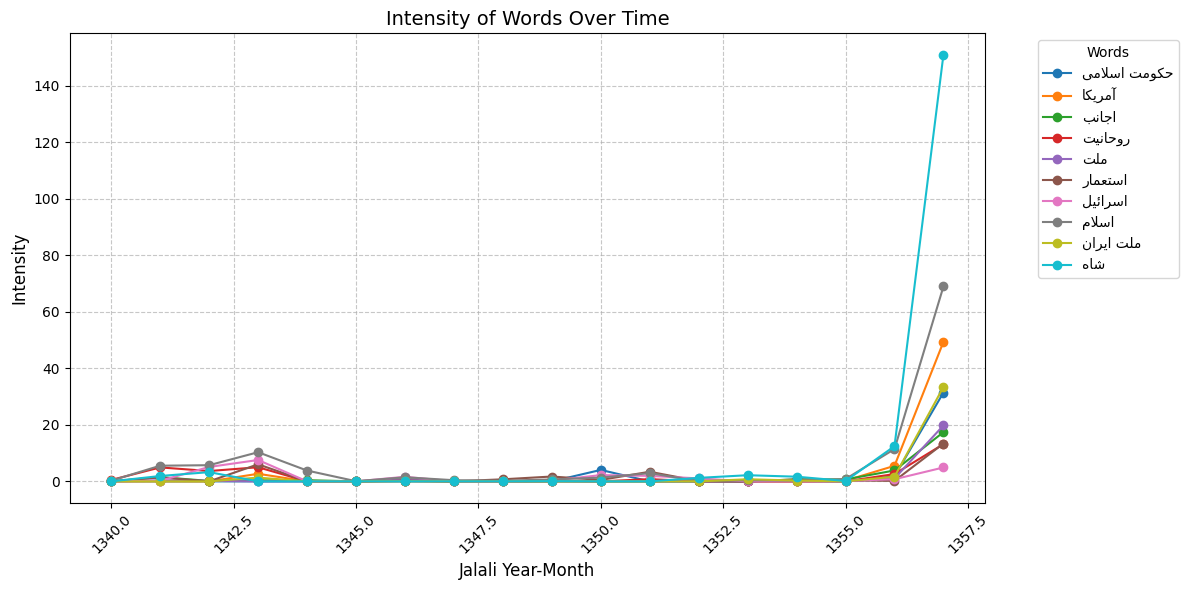

In [ ]:
top_targets = df.groupby('target',as_index=False
                         ).agg( tot_weight = ('weight','sum')
                               ).sort_values(by=['tot_weight'], ascending=False
                                             )[:10]['target'].to_list()
df = df[df['target'].isin(top_targets)] 
# 3. Pivot the data
# Index = Year-Month, Columns = Words, Values = Intensity
# This ensures each word has its own column (and thus a fixed color)
df_pivot = df.pivot_table(index='time', columns='target', values='weight')
# 4. Fill NaNs with 0 if you want the line to drop to zero when the word is absent
# Or leave as NaN if you want gaps in the line
df_pivot = df_pivot.fillna(0)

# 5. Plot
ax = df_pivot.plot(kind='line', marker='o', figsize=(12, 6))

plt.title("Intensity of Most Used Words Over Time", fontsize=14)
plt.xlabel("Jalali Year-Month", fontsize=12)
plt.ylabel("Intensity", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

# Move legend outside because there might be many words
plt.legend(title="Words", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('word_intensity_plot.png')
print("Plot saved as word_intensity_plot.png")

In [505]:
entry

{'دولت': 0.49744}

In [476]:
d = df.iloc[-1].sort_values(ascending=True).tail(10)
fix_persian_text(str(d.index))

"Index([','ﺀﺍﺪﻬﺸﻟﺍﺪﯿﺳ ﺕﺮﻀﺣ ﯼﺍﺮﺑ ﻩﺪﺷ ﻒﻗﻭ ﻞﺤﻣ' ,'ﺎﺑﺭ' ,'ﮏﻧﺎﺑ ﻝﻮﭘ' ,'ﺲﻤﺧ\n,'ﺕﺍﺩﺎﺳ ﻪﺑ ﻪﻧﺎﻋﺍ' ,'ﺭﻮﻣﺍ ﺡﻼﺻﺍ' ,'ﻉﺪﺒﻣ ﻭ ﺭﺎﻔﮐ' ,'ﺎﻤﺷ ﻡﺮﮔ ﺲﻔﻧ'       \nﻥﺎﯾﺎﻗﺁ ﺖﻣﻼﺳ' ,'ﯽﻨﻣ ﻪﯿﻀﻗ'       '],\n      dtype='object')"

In [331]:
print(len(entry.get('targets_normalized')), len(entry.get('targets')), len(entry.get('targets_weight')))

88 88 84
